## Setting Up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%pip install python-gnupg

  Using cached python_gnupg-0.5.2-py2.py3-none-any.whl (20 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install eep153_tools

Note: you may need to restart the kernel to use updated packages.


#### Import Food Price Data and Do data cleaning

In [136]:
from eep153_tools.sheets import read_sheets

food_price = read_sheets("https://docs.google.com/spreadsheets/d/1LGkbkm4NYZqV2Fubt8Px2PXVY_3tH1y2d6wIERyK0jk/edit?usp=sharing",sheet='price_information')

food_information = read_sheets("https://docs.google.com/spreadsheets/d/1LGkbkm4NYZqV2Fubt8Px2PXVY_3tH1y2d6wIERyK0jk/edit?usp=sharing",sheet='food_information')

food_price=food_price.set_index(["Reservation", "Tribe"])
food_information = food_information.set_index(["Food"])
food_price

Key available for students@eep153.iam.gserviceaccount.com.


/srv/conda/lib/python3.9/site-packages/eep153_tools/sheets.py:165: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return df.apply(lambda x: pd.to_numeric(x,errors='ignore'))


Key available for students@eep153.iam.gserviceaccount.com.


Location  \
Reservation                      Tribe                                                            
Navajo Nation                    Navajo                                         Window Rock, AZ   
                                 Navajo                                          Scottsdale, AZ   
Uintah and Ouray Reservation     Ute                                          Fort Duchesne, UT   
                                 Ute                                                  Provo, UT   
Rosebud Indian Reservation       Rosebud Sioux                                      Mission, SD   
                                 Rosebud Sioux                                   Rapid City, SD   
Wind River Reservation           Eastern Shoshone; Northern Arapaho           Fort Washakie, WY   
                                 Eastern Shoshone; Northern Arapaho                  Casper, WY   
Cherokee Nation                  Cherokee - Eastern band                           Whittier, NC   
                                 Cherokee - Eastern band                              Sylva, NC   
                                 Cherokee                                         Tahlequah, OK   
                                 Cherokee                                             Tusla, OK   
Lake Traverse Indian Reservation Sisseton Wahpeton Oyate                           Sisseton, SD   
                                 Sisseton Wahpeton Oyate                          Watertown, SD   
Pine Ridge Reservation           Oglala Sioux                                    Pine Ridge, SD   
                                 Oglala Sioux                                     Watertown, SD   
Gila River Indian Reservation    Akimel O'odham (Pima) & Pee-Posh (Maricopa)        Phoenix, AZ   
                                 Akimel O'odham (Pima) & Pee-Posh (Maricopa)        Phoenix, AZ   
Blackfeet Indian Reservation     Blackfoot (Niitsitapi)                            Browning, MT   
                                 Blackfoot (Niitsitapi)                            Billings, MT   

                                                                                                  Grocery store  \
Reservation                      Tribe                                                                            
Navajo Nation                    Navajo                                                                 Bashas'   
                                 Navajo                                                                 Walmart   
Uintah and Ouray Reservation     Ute                                                      ute_plaza_supermarket   
                                 Ute                                                                    Walmart   
Rosebud Indian Reservation       Rosebud Sioux                                Turtle Creek Crossing Super Foods   
                                 Rosebud Sioux                                                          Walmart   
Wind River Reservation           Eastern Shoshone; Northern Arapaho                                     Smith's   
                                 Eastern Shoshone; Northern Arapaho                                     Walmart   
Cherokee Nation                  Cherokee - Eastern band                                              Food Lion   
                                 Cherokee - Eastern band                                               Walmart    
                                 Cherokee                                                              Reasor's   
                                 Cherokee                                                              Walmart    
Lake Traverse Indian Reservation Sisseton Wahpeton Oyate                                            Buche Foods   
                                 Sisseton Wahpeton Oyate                                               Walmart    
Pine Ridge Reservation           Oglala Sioux                       

In [137]:
food_information['reservation_ave_price'] = np.mean(food_price[food_price['Grocery store']!='Walmart'].iloc[:,2:16], axis=0)
food_information['walmart_ave_price'] = np.mean(food_price[food_price['Grocery store']=='Walmart'].iloc[:,2:16], axis=0)
food_information

,Quantity,Unit,FDC,reservation_ave_price,walmart_ave_price
Food,,,,,
Apple,1.0,pound,454004,1.362857,1.328333
Egg,12.0,xl_egg,1663044,3.377143,2.856667
Ground beef,1.0,pound,1942314,4.885000,4.608333
Loaf of white bread,1.0,pound,2071641,2.441429,1.420000
Whole Milk,1.0,gallon,2340762,3.388571,2.696667
Tomato,1.0,pound,2345232,1.524286,1.696667
Whole Chicken,1.0,pound,2683347,2.468462,1.436667
Carrots,1.0,pound,2345173,1.253571,1.313333
Spaghetti,16.0,oz,2099117,1.445000,0.980000


## Helpful Data Analysis Plots

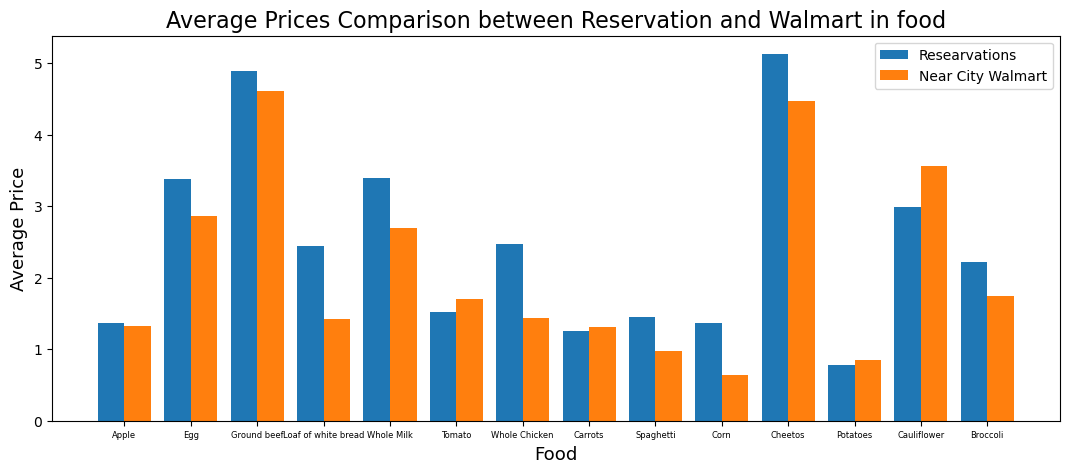

In [117]:
plt.figure(figsize=(13,5))
X = food_information.index 
Y_reservation_average_price = food_information['reservation_ave_price']
Z_walmart_ave_price = food_information['walmart_ave_price']
  
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis - 0.2, Y_reservation_average_price, 0.4, label = 'Researvations') 
plt.bar(X_axis + 0.2, Z_walmart_ave_price, 0.4, label = 'Near City Walmart') 
  
plt.xticks(X_axis, X, fontsize=6) 
plt.xlabel("Food", fontsize=13) 
plt.ylabel("Average Price", fontsize=13) 
plt.title("Average Prices Comparison between Reservation and Walmart in food",fontsize=16) 
plt.legend() 
plt.show() 

## Minimum Subsistance Food Cost

In [8]:
apikey = "PYsA9PuIqBESOYtWIQtsYmRj1wHxQd52DHjDr0Hl"

In [9]:
%pip install -r requirements.txt --upgrade

  Using cached gspread-6.0.2-py3-none-any.whl (53 kB)
  Using cached StrEnum-0.4.15-py3-none-any.whl (8.9 kB)
Note: you may need to restart the kernel to use updated packages.


In [10]:
import fooddatacentral as fdc

### Define `solve_subsistence_problem`  function

In [40]:
from  scipy.optimize import linprog as lp
import numpy as np
import warnings

def solve_subsistence_problem(FoodNutrients,Prices,dietmin,dietmax,max_weight=None,tol=1e-6):
    """Solve Stigler's Subsistence Cost Problem.

    Inputs:
       - FoodNutrients : A pd.DataFrame with rows corresponding to nutrients, columns to food.
       - Prices : A pd.Series of prices for different foods
       - diet_min : A pd.Series of DRIs, with index corresponding to columns of FoodNutrients,
                    describing minimum intakes.
       - diet_max : A pd.Series of DRIs, with index corresponding to columns of FoodNutrients,
                    describing maximum intakes.
       - max_weight : Maximum weight (in hectograms) allowed for diet.
       - tol : Solution values smaller than this in absolute value treated as zeros.
       
    """
    try: 
        p = Prices.apply(lambda x:x.magnitude)
    except AttributeError:  # Maybe not passing in prices with units?
        warnings.warn("Prices have no units.  BE CAREFUL!  We're assuming prices are per hectogram or deciliter!")
        p = Prices

    p = p.dropna()

    # Compile list that we have both prices and nutritional info for; drop if either missing
    use = p.index.intersection(FoodNutrients.columns)
    p = p[use]

    # Drop nutritional information for foods we don't know the price of,
    # and replace missing nutrients with zeros.
    Aall = FoodNutrients[p.index].fillna(0)

    # Drop rows of A that we don't have constraints for.
    Amin = Aall.loc[Aall.index.intersection(dietmin.index)]
    Amin = Amin.reindex(dietmin.index,axis=0)
    idx = Amin.index.to_frame()
    idx['type'] = 'min'
    #Amin.index = pd.MultiIndex.from_frame(idx)
    #dietmin.index = Amin.index
    
    Amax = Aall.loc[Aall.index.intersection(dietmax.index)]
    Amax = Amax.reindex(dietmax.index,axis=0)
    idx = Amax.index.to_frame()
    idx['type'] = 'max'
    #Amax.index = pd.MultiIndex.from_frame(idx)
    #dietmax.index = Amax.index

    # Minimum requirements involve multiplying constraint by -1 to make <=.
    A = pd.concat([Amin,
                   -Amax])

    b = pd.concat([dietmin,
                   -dietmax]) # Note sign change for max constraints

    # Make sure order of p, A, b are consistent
    A = A.reindex(p.index,axis=1)
    A = A.reindex(b.index,axis=0)

    if max_weight is not None:
        # Add up weights of foods consumed
        A.loc['Hectograms'] = -1
        b.loc['Hectograms'] = -max_weight
        
    # Now solve problem!  (Note that the linear program solver we'll use assumes
    # "less-than-or-equal" constraints.  We can switch back and forth by
    # multiplying $A$ and $b$ by $-1$.)

    result = lp(p, -A, -b, method='highs')

    result.A = A
    result.b = b
    
    if result.success:
        result.diet = pd.Series(result.x,index=p.index)
    else: # No feasible solution?
        warnings.warn(result.message)
        result.diet = pd.Series(result.x,index=p.index)*np.nan  

    return result

#### Units & Price

In [138]:
food_information['FDC Quantity'] = food_information[['Quantity','Unit']].T.apply(lambda x : fdc.units(x['Quantity'],x['Unit']))

# Now divide price by the FDC Quantity to get, e.g., price per hectoliter
food_information['FDC_reservation_ave_price'] = food_information['reservation_ave_price']/food_information['FDC Quantity']
food_information['FDC_walmart_ave_price']=food_information['walmart_ave_price']/food_information['FDC Quantity']
food_information.dropna(how='any') # Drop food with any missing data

# To use minimum price observed
Reservation_Prices = food_information.groupby('Food')['FDC_reservation_ave_price'].min()
Near_city_walmart_price=food_information.groupby('Food')['FDC_walmart_ave_price'].min()
Reservation_Prices

/srv/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1598: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


Food
Apple                  0.30045856874910454 / hectogram
Broccoli               0.48958369509484595 / hectogram
Carrots                0.27636519295318573 / hectogram
Cauliflower             0.6594971100216195 / hectogram
Cheetos                  2.126972022353432 / hectogram
Corn                    0.3214969674833186 / hectogram
Egg                     0.5025510204081632 / hectogram
Ground beef             1.0769581507731265 / hectogram
Loaf of white bread     0.5382428658199367 / hectogram
Potatoes               0.17211803754862226 / hectogram
Spaghetti              0.31856796885714805 / hectogram
Tomato                 0.33604747678752056 / hectogram
Whole Chicken            0.544202614885594 / hectogram
Whole Milk             0.08951658688478975 / deciliter
Name: FDC_reservation_ave_price, dtype: object

#### Map Nutritions

In [139]:
import warnings

D = {}
count = 0
for food in  food_information.index:
    try:
        FDC = food_information.loc[food_information.index==food,:].FDC.values[0]
        count+=1
        D[food] = fdc.nutrients(apikey,FDC).Quantity
        print(food)
    except AttributeError:
        warnings.warn(f"Couldn't find FDC Code {FDC} for food {food}.")

FoodNutrients= pd.DataFrame(D,dtype=float)
FoodNutrients

Apple
Egg
Ground beef
Loaf of white bread
Whole Milk
Tomato
Whole Chicken
Carrots
Spaghetti
Corn
Cheetos
Potatoes
Cauliflower
Broccoli


,Apple,Egg,Ground beef,Loaf of white bread,Whole Milk,Tomato,Whole Chicken,Carrots,Spaghetti,Corn,Cheetos,Potatoes,Cauliflower,Broccoli
"Alcohol, ethyl",NaN,NaN,NaN,NaN,0.00,0.00,NaN,0.00,NaN,0.00,0.00,NaN,NaN,NaN
Ash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.61,NaN,NaN
Caffeine,NaN,NaN,NaN,NaN,0.00,0.00,NaN,0.00,NaN,0.00,0.00,NaN,NaN,NaN
"Calcium, Ca",0.00,63.00,18.0,0.00,123.00,10.00,NaN,33.00,0.00,3.00,56.00,30.00,0.00,47.00
"Carbohydrate, by difference",14.29,0.00,0.0,42.22,4.63,4.04,0.0,9.58,76.79,13.90,53.50,12.44,2.35,4.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Vitamin E, added",NaN,NaN,NaN,NaN,0.00,0.00,NaN,0.00,NaN,0.00,0.00,NaN,NaN,NaN
Vitamin K (phylloquinone),NaN,NaN,NaN,NaN,0.30,7.50,NaN,13.20,NaN,3.20,1.30,NaN,NaN,NaN
Vitamins and Other Components,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN
Water,NaN,NaN,NaN,NaN,88.10,94.40,NaN,88.30,NaN,79.00,1.57,83.29,NaN,NaN


### Dietary Requirements

In [140]:
from eep153_tools.sheets import read_sheets

DRI_url = "https://docs.google.com/spreadsheets/d/1y95IsQ4HKspPW3HHDtH7QMtlDA66IUsCHJLutVL-MMc/"

DRIs = read_sheets(DRI_url)

# Define *minimums*
diet_min = DRIs['diet_minimums'].set_index('Nutrition')

# Define *maximums*
diet_max = DRIs['diet_maximums'].set_index('Nutrition')

Key available for students@eep153.iam.gserviceaccount.com.


/srv/conda/lib/python3.9/site-packages/eep153_tools/sheets.py:150: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  D[w.title]=df.apply(lambda x: pd.to_numeric(x,errors='ignore'))


### Using `solve_subsistence_problem` to analyze Reservation Population Diet

In [148]:
group = 'F 19-30'
tol = 1e-6

result = solve_subsistence_problem(FoodNutrients,Reservation_Prices,diet_min[group],diet_max[group],tol=tol)

print("Cost of diet for %s is $%4.2f per day.\n" % (group,result.fun))

# Put back into nice series
diet = result.diet

print("\nDiet (in 100s of grams or milliliters):")
print(diet[diet >= tol])  # Drop items with quantities less than precision of calculation.
print()

tab = pd.DataFrame({"Outcome":np.abs(result.A).dot(diet),"Recommendation":np.abs(result.b)})
print("\nWith the following nutritional outcomes of interest:")
print(tab)
print()

print("\nConstraining nutrients are:")
excess = tab.diff(axis=1).iloc[:,1]
print(excess.loc[np.abs(excess) < tol*100].index.tolist())

Cost of diet for F 19-30 is $7.22 per day.


Diet (in 100s of grams or milliliters):
Carrots       22.390572
Potatoes       3.276800
Spaghetti      0.207475
Whole Milk     4.444444
dtype: float64


With the following nutritional outcomes of interest:
                                     Outcome  Recommendation
Nutrition                                                   
Energy                           2063.190217          2000.0
Protein                            46.000000            46.0
Fiber, total dietary               71.632514            28.0
Folate, DFE                       481.126484           400.0
Calcium, Ca                      1383.859570          1000.0
Carbohydrate, by difference       291.774863           130.0
Iron, Fe                           18.000000            18.0
Magnesium, Mg                     397.386613           310.0
Niacin                             26.972978            14.0
Phosphorus, P                    1357.077341           700.0
Potassium, K     

### Using `solve_subsistence_problem` to analyze Near City Walmart Population Diet

In [149]:
group = 'F 19-30'
tol = 1e-6

result = solve_subsistence_problem(FoodNutrients,Near_city_walmart_price,diet_min[group],diet_max[group],tol=tol)

print("Cost of diet for %s is $%4.2f per day.\n" % (group,result.fun))

# Put back into nice series
diet = result.diet

print("\nDiet (in 100s of grams or milliliters):")
print(diet[diet >= tol])  # Drop items with quantities less than precision of calculation.
print()

tab = pd.DataFrame({"Outcome":np.abs(result.A).dot(diet),"Recommendation":np.abs(result.b)})
print("\nWith the following nutritional outcomes of interest:")
print(tab)
print()

print("\nConstraining nutrients are:")
excess = tab.diff(axis=1).iloc[:,1]
print(excess.loc[np.abs(excess) < tol*100].index.tolist())

Cost of diet for F 19-30 is $7.07 per day.


Diet (in 100s of grams or milliliters):
Carrots       19.058812
Corn           3.926718
Potatoes       3.463624
Whole Milk     4.444444
dtype: float64


With the following nutritional outcomes of interest:
                                     Outcome  Recommendation
Nutrition                                                   
Energy                           2251.514418          2000.0
Protein                            49.876856            46.0
Fiber, total dietary               69.484498            28.0
Folate, DFE                       562.360880           400.0
Calcium, Ca                      1291.296337          1000.0
Carbohydrate, by difference       300.830059           130.0
Iron, Fe                           18.000000            18.0
Magnesium, Mg                     412.749765           310.0
Niacin                             26.611879            14.0
Phosphorus, P                    1424.267327           700.0
Potassium, K     